<a href="https://colab.research.google.com/github/Harsha080996/ML-assignments/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem 1: Feature extraction with data augmentation**

In [1]:
#images for cats and dogs from google
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 02:41:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  76.3MB/s    in 0.9s    

2019-04-17 02:41:11 (76.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
from keras.applications import VGG19 #Downloading VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 7s 0us/step


In [5]:
conv_base.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

**Freezing the convulutional base**

In [0]:
conv_base.trainable = False  

In [7]:
#Extracting features from last layer in VGG19
for last_layer in conv_base.layers:
  last_layer.trainable = False
  
new_layer = conv_base.get_layer('block5_pool')
print('output shape of last layer is', new_layer.output_shape)
new_output = new_layer.output

output shape of last layer is (None, 4, 4, 512)


**Concatenate the convolutional base and densely connected layers**

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#no dropout
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


**Train the model end to end with frozen convolutional base**

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 23s 229ms/step - loss: 0.6127 - acc: 0.6640 - val_loss: 0.4986 - val_acc: 0.7750
Epoch 2/30
100/100 [==============================] - 18s 179ms/step - loss: 0.5199 - acc: 0.7585 - val_loss: 0.4190 - val_acc: 0.8150
Epoch 3/30
100/100 [==============================] - 19s 193ms/step - loss: 0.4721 - acc: 0.7790 - val_loss: 0.3719 - val_acc: 0.8410
Epoch 4/30
100/100 [==============================] - 18s 182ms/step - loss: 0.4445 - acc: 0.8030 - val_loss: 0.3507 - val_acc: 0.8540
Epoch 5/30
100/100 [==============================] - 18s 177ms/step - loss: 0.4283 - acc: 0.8080 - val_loss: 0.3379 - val_acc: 0.8590
Epoch 6/30
100/100 [==============================] - 18s 184ms/step - loss: 0.4125 - acc: 0.8165 - val_loss: 0.3175 - val_acc: 0.8530
Epoch 7/30
100/100 [==============================] - 19s 

**Display curves of loss and accuracy during training**

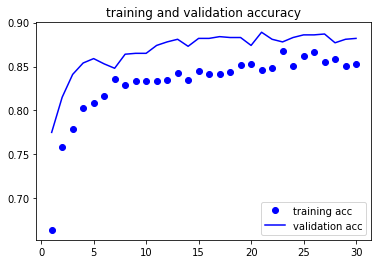

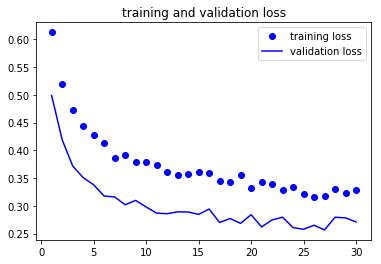

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

**Problem 2: Fine tuning with data augmentation**

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

**Training with smaller learning rate**

In [13]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])
model.summary()

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 11,536,897
Non-trainable params: 10,585,152
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 21s 208ms/step - loss: 0.3309 - acc: 0.8475 - val_loss: 0.2801 - val_acc: 0.8860
Epoch 2/100
100/100 [==============================] - 19s 186ms/step - loss: 0.2735 - acc: 0.8800 - val_loss: 0.2624

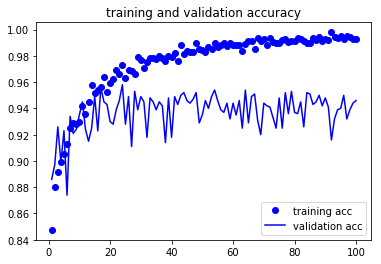

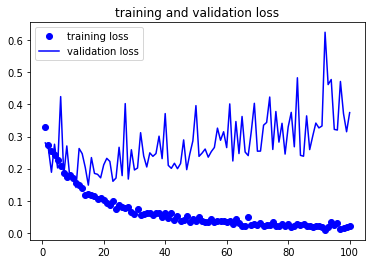

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [15]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: [0.280052949488163, 0.2623970056883991, 0.188663087785244, 0.2760199823603034, 0.20222021237015725, 0.4246069499850273, 0.17925276787951588, 0.27070756698027254, 0.17015855507925154, 0.17580389739014207, 0.14119857864454388, 0.26275565443560484, 0.24657889747060835, 0.20384431605692954, 0.14854507090058178, 0.2344605913385749, 0.18509444305556827, 0.1822352900239639, 0.17128043372649698, 0.21167945233173668, 0.2320498254755512, 0.22241638423409313, 0.16047973915236072, 0.1706724752811715, 0.26654612260870636, 0.17820973621448502, 0.4027697864244692, 0.16741864281793822, 0.2588481782976305, 0.19577831997768955, 0.20193016435485334, 0.31204566307947973, 0.23960487115196882, 0.20514988098566392, 0.24920308716595174, 0.23835649235639722, 0.2469785211549606, 0.30123078904329303, 0.231108023669658, 0.3716223797299608, 0.2101743267314123, 0.20087905975116882, 0.21676657291362061, 0.19976241794065572, 0.2159064024881809, 0.28956208545554546, 0.1968471826700261, 0.2454486027886